## Optimization :


In [1]:
from utility.data_loader import load_parquet_data
from utility.data_transformer import transform_data
import utility.wt_comparision as wt_comparision
from pathlib import Path
import lib_optimizers.scipy_solvers as scipy_solvers
import lib_optimizers.osqp as osqp
from optimizers.ipm_optimizer import solve_with_ipm, plot_ipm_convergence
from optimizers.ipm_with_hirarchy_constraint import solve_with_ipm_complete
import optimizers.newtons_method as newtons_method
import optimizers.cg_optimizer as cg_optimizer


In [2]:
faireness_coefficient = 0.5
regularization_coefficient=0.2

In [3]:
# Load the data
parquet_file_path = Path().absolute().parent / 'data' / 'breuninger_user_product_event_counts_000000000000'
my_data_df = load_parquet_data(str(parquet_file_path), engine='pyarrow')  

# Transform the data only if DataFrame is loaded successfully
if my_data_df is not None:
	data_for_optimization = transform_data(my_data_df, lambda_1=faireness_coefficient, lambda_2=regularization_coefficient)
else:
	raise ValueError("Failed to load data from parquet file")

In [4]:
hierarchy = [
    ('purchase', 'add_to_cart'),          # purchase >= add_to_cart
    ('add_to_cart', 'add_to_wishlist'),   # add_to_cart >= add_to_wishlist
    ('add_to_wishlist', 'product_view')   # add_to_wishlist >= product_view
]

# List to collect all weight vectors for comparison
all_weight_results = []



Projected Newton's Method Execution (K=5 Features)
Goal: Minimize g(w) = 1/2 w^T Q w - c^T w, subject to Simplex Constraints
--- Initial Setup ---
  > Initial Objective (Min g(w)): -85066.727304
  > Initial Weights: add_to_cart: 0.2000, add_to_wishlist: 0.2000, product_view: 0.2000, purchase: 0.2000, view_cart: 0.2000
--- Iteration 01 ---
  > Current Objective (Min g(w)): -314199.563433
  > Gradient Norm: 321957.997646
  > Step Change (|w_next - w|): 0.894427
  > Current Weights: add_to_cart: 0.0000, add_to_wishlist: 0.0000, product_view: 1.0000, purchase: 0.0000, view_cart: 0.0000
--- Iteration 02 ---
  > Current Objective (Min g(w)): -314199.563433
  > Gradient Norm: 321956.826672
  > Step Change (|w_next - w|): 0.000000
  > Current Weights: add_to_cart: 0.0000, add_to_wishlist: 0.0000, product_view: 1.0000, purchase: 0.0000, view_cart: 0.0000

[INFO] CONVERGENCE: Step change is below tolerance.

[INFO] Total Iterations: 2
[INFO] Time elapsed: 0.0003 seconds

[INFO] Plotting converg

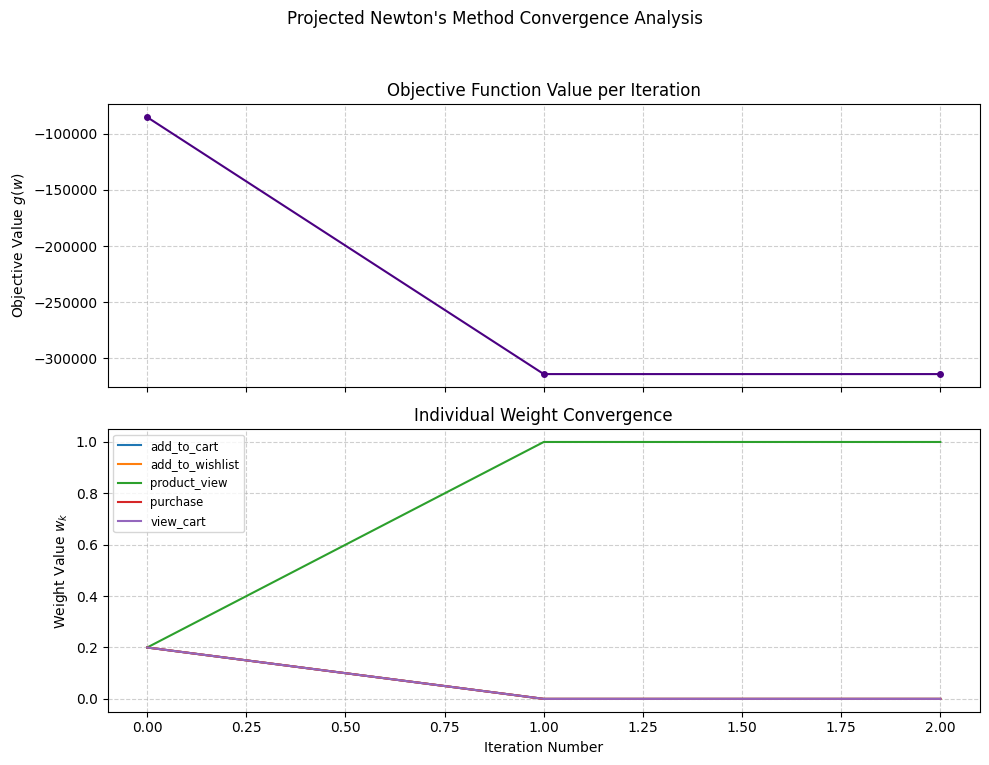

In [5]:
# Newton's Method Optimization
result_newtons_method=newtons_method.solve_with_projected_newtons_method(data_for_optimization['Q_solver'], data_for_optimization['c'], data_for_optimization['weight_names'] )
if 'history' in result_newtons_method and result_newtons_method['history']:
        print("\n[INFO] Plotting convergence history...")
        newtons_method.plot_convergence(result_newtons_method['history'], data_for_optimization['weight_names'])

all_weight_results.append({**result_newtons_method, 'weight_names': data_for_optimization['weight_names']})



Projected Conjugate Gradient Method Execution (K=5 Features)
Goal: Minimize g(w) = 1/2 w^T Q w - c^T w, subject to Simplex Constraints
--- Initial Setup ---
  > Initial Objective (Min g(w)): -85066.727304
  > Initial Weights: add_to_cart: 0.2000, add_to_wishlist: 0.2000, product_view: 0.2000, purchase: 0.2000, view_cart: 0.2000
--- Iteration 01 ---
  > Current Objective: -85066.727304
  > Step Change: 0.894427
  > Current Weights: add_to_cart: 0.0000, add_to_wishlist: 0.0000, product_view: 1.0000, purchase: 0.0000, view_cart: 0.0000
--- Iteration 02 ---
  > Current Objective: -314199.563433
  > Step Change: 0
  > Current Weights: add_to_cart: 0.0000, add_to_wishlist: 0.0000, product_view: 1.0000, purchase: 0.0000, view_cart: 0.0000

[INFO] CONVERGENCE: Step change (0.00e+00) is below tolerance (1.00e-07).

[INFO] Total Iterations: 3
[INFO] Time elapsed: 0.0003 seconds
[INFO] Final Sum of Weights: 1.0

[INFO] Plotting convergence history...


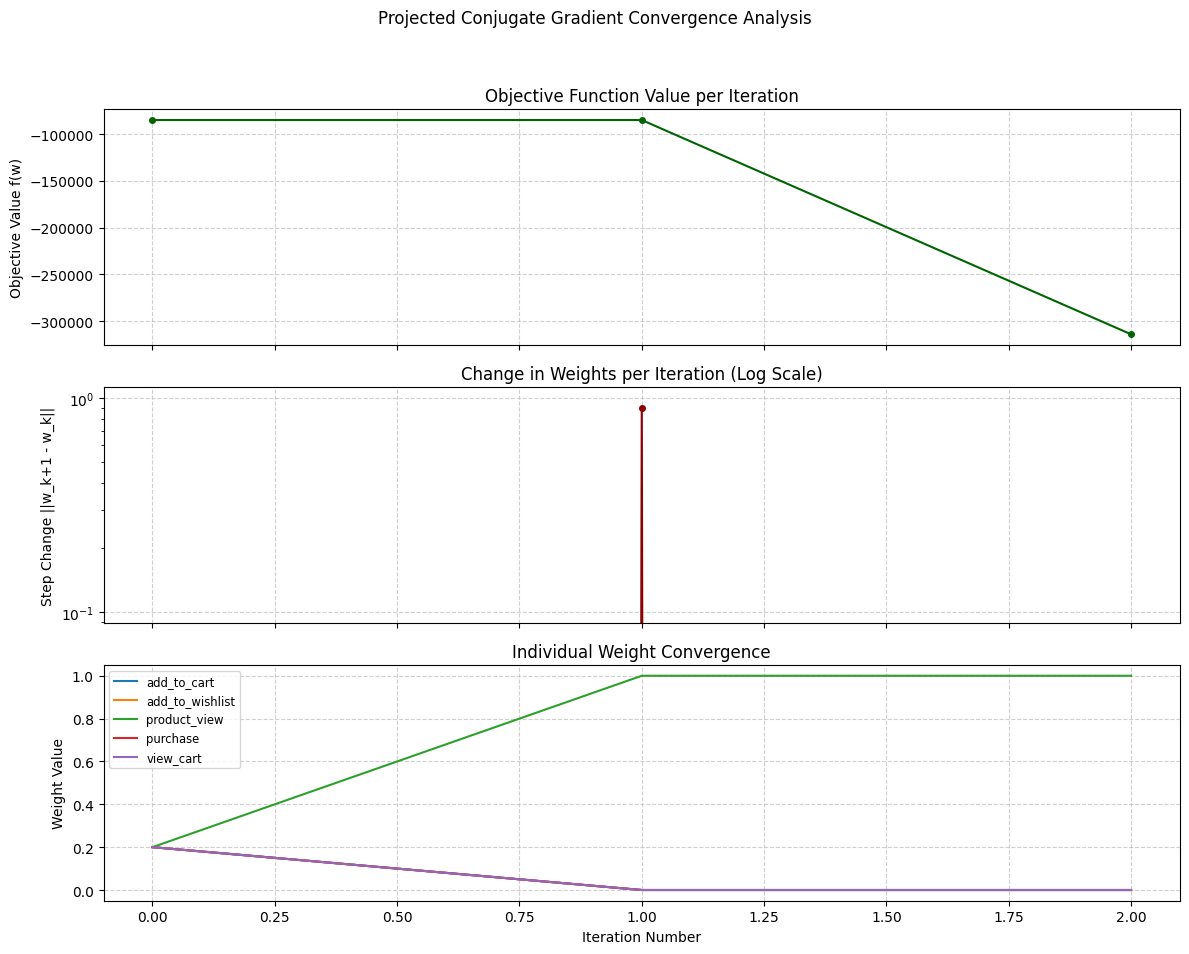

In [6]:
# Conjugate Gradient Method Optimization
result_cg_method=cg_optimizer.solve_with_conjugate_gradient(data_for_optimization['Q_solver'], data_for_optimization['c'], data_for_optimization['weight_names'] )
if 'history' in result_cg_method and result_cg_method['history']:
        print("\n[INFO] Plotting convergence history...")
        cg_optimizer.plot_cg_convergence(result_cg_method['history'], data_for_optimization['weight_names'])  
all_weight_results.append({**result_cg_method, 'weight_names': data_for_optimization['weight_names']})

In [7]:
result = scipy_solvers.solve_constrained_quadratic(data_for_optimization['Q_solver'], data_for_optimization['c'], data_for_optimization['weight_names'], hierarchy=hierarchy,method='trust-constr')

all_weight_results.append({**result, 'weight_names': data_for_optimization['weight_names']})
print(f"Max Objective Score (f(w)): {result['max_f_w']}")
print(result['weights_df'])

Max Objective Score (f(w)): 90369.21013878148
         Weight          Feature
0  2.499999e-01      add_to_cart
1  2.499997e-01  add_to_wishlist
2  2.499996e-01     product_view
3  2.500000e-01         purchase
4  9.114964e-07        view_cart



Primal-Dual Interior Point Method Execution (K=5 Features, J=3 Hierachy Constraints)
Iter   1 | Gap: 1.25e-02 | Obj: -6.7922e+04 | Alpha: 0.000
Iter  10 | Gap: 1.30e-01 | Obj: -2.0267e+05 | Alpha: 0.000
Iter  20 | Gap: 1.30e-01 | Obj: -3.1420e+05 | Alpha: 0.000
Iter  30 | Gap: 3.99e-01 | Obj: -3.1420e+05 | Alpha: 0.000
Iter  40 | Gap: 1.11e-01 | Obj: -3.1420e+05 | Alpha: 0.074
Iter  50 | Gap: 9.55e-02 | Obj: -3.1420e+05 | Alpha: 0.000
Iter  60 | Gap: 8.38e-02 | Obj: -3.1420e+05 | Alpha: 0.000
Iter  70 | Gap: 1.49e+00 | Obj: -3.1420e+05 | Alpha: 0.000
Iter  80 | Gap: 1.15e+00 | Obj: -3.1420e+05 | Alpha: 0.000
Iter  90 | Gap: 9.28e-02 | Obj: -3.1420e+05 | Alpha: 0.000
Iter 100 | Gap: 1.20e-01 | Obj: -3.1420e+05 | Alpha: 0.000

Optimization Complete in 0.0269 seconds.
Final Weights: {'add_to_cart': np.float64(3.989355015288199e-08), 'add_to_wishlist': np.float64(2.2912087313359334e-08), 'product_view': np.float64(0.9999999138751011), 'purchase': np.float64(1.155520998537021e-08), 'view_c

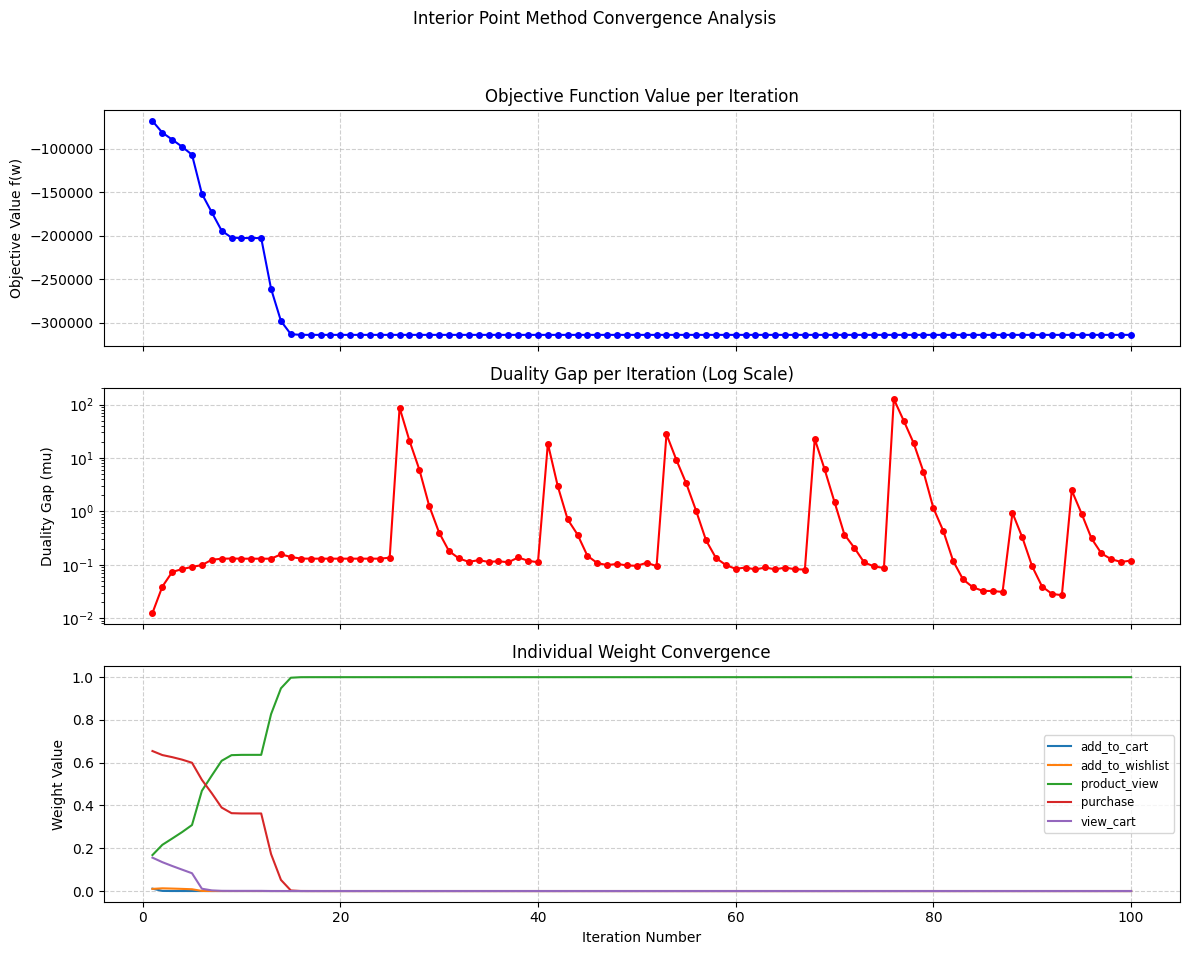

In [8]:

# Solve with IPM Solver with hirarchy
res_ipm_complete = solve_with_ipm_complete(data_for_optimization['Q_solver'], data_for_optimization['c'], data_for_optimization['weight_names'] )

if 'history' in res_ipm_complete and res_ipm_complete['history']:
    print("\n[INFO] Plotting IPM convergence history...")
    plot_ipm_convergence(res_ipm_complete['history'], data_for_optimization['weight_names']) 
all_weight_results.append({**res_ipm_complete, 'weight_names': data_for_optimization['weight_names']})

In [9]:
result = osqp.minimizeUsingOsQP(data_for_optimization['Q_solver'], data_for_optimization['c'], data_for_optimization['weight_names'], hierarchy=hierarchy)

all_weight_results.append({**result, 'weight_names': data_for_optimization['weight_names']})
print(f"Max Objective Score (f(w)): {result['max_f_w']}")
print(result['weights_df'])

OSQP (ADMM) Optimal Weights (w*):
[('add_to_cart', np.float64(0.2499850402055159)), ('add_to_wishlist', np.float64(0.2500121534332511)), ('product_view', np.float64(0.250037387787551)), ('purchase', np.float64(0.2499677331521709)), ('view_cart', np.float64(-2.311194184046576e-06))]
OSQP Minimum Objective Value: -90380.49897833126
OSQP Status: solved
Max Objective Score (f(w)): 90380.49897833126
       Weight_Name  Optimal_Weight
0      add_to_cart        0.249985
1  add_to_wishlist        0.250012
2     product_view        0.250037
3         purchase        0.249968
4        view_cart       -0.000002


Visualization



--- Generating Final Score Comparison ---


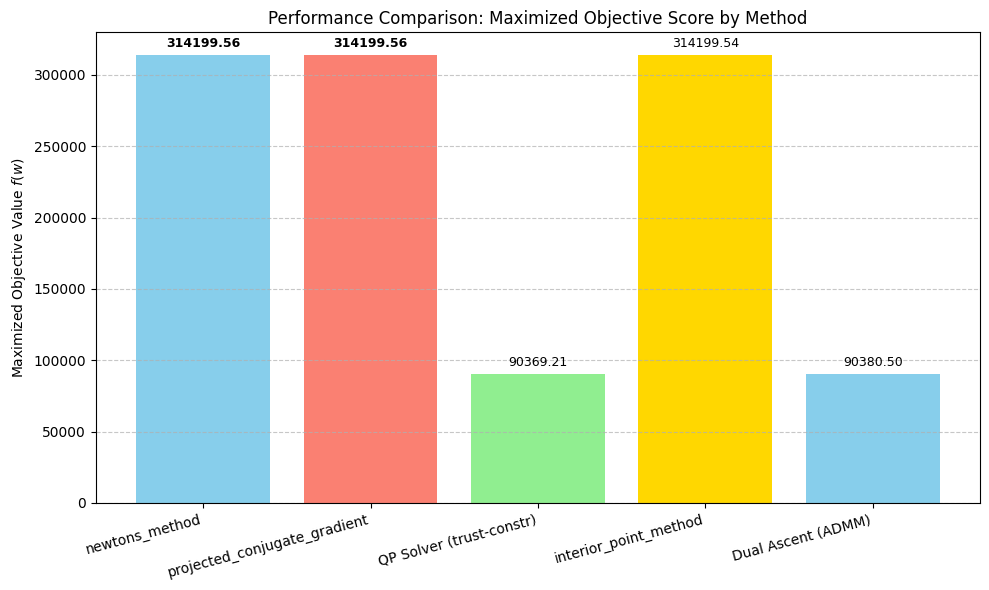

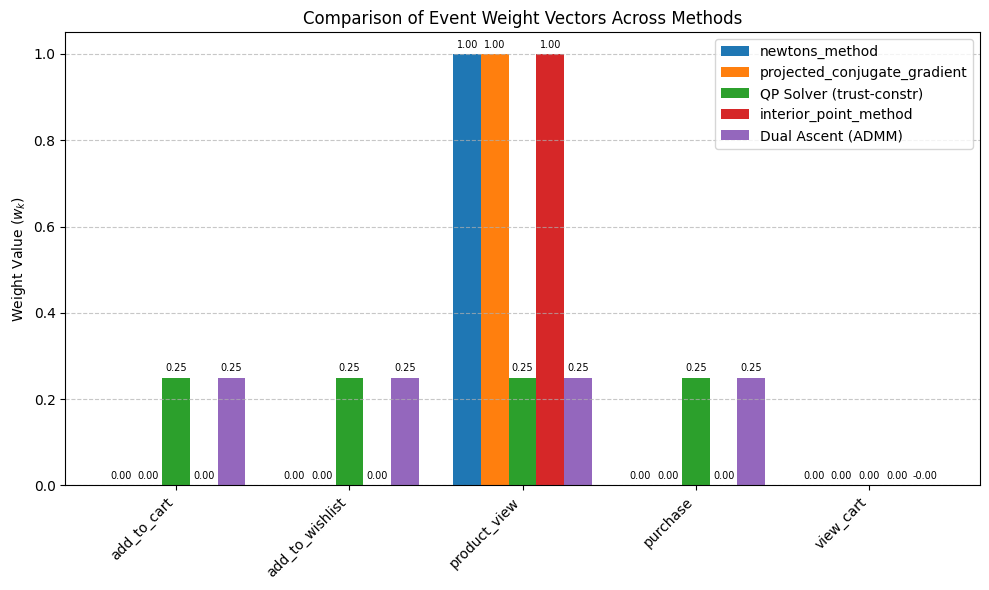


--- Best Optimization Method Found ---
Method: newtons_method
Max Objective Score (f(w)): 314199.5634

Weights for the Best Method:
                 Weight
Event                  
add_to_cart         0.0
add_to_wishlist     0.0
product_view        1.0
purchase            0.0
view_cart           0.0


In [10]:
#Visualize the Final Scores =
print("\n\n--- Generating Final Score Comparison ---")
wt_comparision.visualize(data_for_optimization,all_weight_results)